In [28]:
# %load notebook_setup.py
#Use %load notebook_setup.py to load these commands at the top of your
#ipython notebook.  Includes running the std_libraries.py file. 

%run std_libraries.py
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
%matplotlib inline
#%matplotlib notebook

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
home directory is /home/heineike/
y1000plus_tools dir is /home/heineike/github/y1000plus_tools/
y1000plus data dir is /home/heineike/genomes/y1000plus/
Importing y1000plus_tools.py
importing io_library.py
sys.path : 

['/home/heineike/github/y1000plus_tools/scripts', '', '/home/lab/envs/seqanalysis/lib/python35.zip', '/home/lab/envs/seqanalysis/lib/python3.5', '/home/lab/envs/seqanalysis/lib/python3.5/plat-linux', '/home/lab/envs/seqanalysis/lib/python3.5/lib-dynload', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/argh-0.26.1-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/glob2-0.4.1-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/mmtf_python-1.0.2-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/IPython/extensions', '/home/heineike/.ipython', '/home/heineike/github/y1000

In [ ]:
# #Only need to do once
# #Gets AA sequence from YGOB genome.tab and sequence.fas file and deposits them 
# #in a file.
# #only works on gpucluster right now because that's where the genomes are

# specs = ['Suva', 'Smik', 'Lwal', 'Ncas', 'Klac']

# for spec in specs: 
#     io_library.ygob_AA_extract(spec)

#At least one bad sequence in Ncas chromosome 1
#At least one bad sequence in suva_Chr_2
#At least one bad sequence in Klac chromosome 1

In [2]:
y1000plus_dir

'/home/heineike/genomes/y1000plus/'

In [36]:
y1000_species = pd.read_csv(y1000plus_dir + "y1000_species_table.csv", index_col=0)

#Select only clades of interest: 
#clades_of_interest = {'Saccharomycetaceae','Saccharomycodaceae','Phaffomycetaceae','CUG-Ser2','CUG-Ser1','Pichiaceae','CUG-Ala'}
clades_of_interest = {'Saccharomycetaceae', 'Saccharomycodaceae'}
outgroups = [ 'Wickerhamomyces anomalus','Cyberlindnera jadinii', 'Ascoidea rubescens','Komagataella pastoris','Debaryomyces hansenii', 'Candida albicans', 'Yarrowia lipolytica']
#outgroup = 'Yarrowia lipolytica'

y1000_species_subset = y1000_species[(y1000_species['Major clade'].isin(clades_of_interest))  |  (y1000_species['Species name'].isin(outgroups))]


#outgroup = 'Hanseniaspora vineae'  #For EGO2/4 - only Sacch so use different outgroup
#y1000_species_subset = pd.concat([y1000_species_subset, y1000_species[y1000_species['Species name']==outgroup]])
#y1000_species_subset

In [44]:
y1000_species[y1000_species['old_species_names']=='Kluyveromyces_lactis']

,original_genome_id,old_species_names,species_names_fig2,hex,id_table S1,Species name,Major clade,clade_order,Family,Genus,CUG usage,spec_og_id
ID,,,,,,,,,,,,
267,kluyveromyces_lactis,Kluyveromyces_lactis,Kluyveromyces_lactis,#0012ff,270,Kluyveromyces lactis,Saccharomycetaceae,12,Saccharomycetaceae,Kluyveromyces,Leu,50


In [ ]:
#I thought that the pep.max list had a bunch of duplicates that the numbered list would not, but the numbered list does have duplicates.  
#No need to make AA lists, but code for that is below

In [55]:
#For a given species, go through full protein list and make a new file with just the proteins from that species

# use 'old_species_names' column
spec_old = 'Kluyveromyces_lactis'
spec_orig = 'kluyveromyces_lactis'  #original_genome_id to save filename

new_fname = y1000plus_dir + os.path.normpath('AA_lists/' + spec_orig + '.fasta')

with open(new_fname,'w') as f: 
    for seq in SeqIO.parse(y1000plus_dir + "343taxa_proteins.fasta", "fasta"):
        if spec_old in seq.id: 
            f.write(">" + seq.description + '\n')
            f.write(str(seq.seq) + '\n')
            

In [ ]:
#Find matches using genome search

study1 = 'YGOB'
study2 = 'y1000'

spec = 'Klac'
#spec_old = 'Kluyveromyces_lactis'
spec_orig = 'kluyveromyces_lactis'  #original_genome_id to save filename


use_subset = False
#subset = set(ambiguous_list_flat)
pairwise_score_loaded = False #if you have already saved some and want to do the rest

match_points = 1
mismatch_points = -1
gap_open = -.5
gap_extension = -0.1
NN_top_scores = 5

#Just load second one into 
#Check timing with time module
#python parallel programming library
#ipy_parallel dask
#https://ipyparallel.readthedocs.io/en/stable/development/messages.html#parallel-messages

#All by all blast, output top NN results

#right now only set up to do y1000 as study2
AA_seqs_fnames = {'regev': io_library.data_processing_dir + os.path.normpath('ortholog_files_regev/AA_lists/' + spec + '_AA_list.fasta'), 
                  'YGOB' : io_library.data_processing_dir + os.path.normpath('ortholog_files_YGOB/AA_lists/' + spec + '_AA_list.fasta'),
                  'y1000': y1000plus_dir + os.path.normpath('AA_lists/' + spec_orig + '.fasta')
                 }

#AA_seqs_study2 = SeqIO.parse(AA_seqs_fnames[study2], "fasta")

idfuncs= {}

for study, name in [('study1',study1), ('study2',study2)]:
    if name == 'y1000': 
        idfuncs[study] = gene_name_function_y1000
    else: 
        if spec=='Smik': 
            idfuncs[study] = gene_name_function_YGOB_regev_Smik
        else: 
            idfuncs[study] = gene_name_function_YGOB_regev
    
genenames_study1 = []
AA_seqs_study1 = SeqIO.parse(AA_seqs_fnames[study1], "fasta")
for seq_study1 in AA_seqs_study1: 
    genename_study1 = idfuncs['study1'](seq_study1)
    genenames_study1.append(genename_study1)
    
if use_subset: 
    print('Using Subset genes')
else: 
    subset = set(genenames_study1)
    
if pairwise_score_loaded: 
    genes_to_search = ((subset & set(genenames_study1)) - set(pairwise_score.keys()))
else: 
    pairwise_score = {}
    genes_to_search = (subset & set(genenames_study1))



AA_seqs_study1 = SeqIO.parse(AA_seqs_fnames[study1], "fasta")

N = len(genes_to_search)
for seq_study1 in AA_seqs_study1: 
    check_gene = False
    genename_study1 = idfuncs['study1'](seq_study1)
    if (pairwise_score_loaded | use_subset):   #checks if gene is in genes tosearch list if either pairwise_score already has been initialized or if we are using a subset of genes
        if genename_study1 in genes_to_search:
            check_gene = True
    else: 
        check_gene=True
        
    if check_gene: 
        print(str(N) + ' ' + genename_study1)
        AA_seqs_study2 = SeqIO.parse(AA_seqs_fnames[study2], "fasta")
        pairwise_score_comps = {}
        for seq_study2 in AA_seqs_study2: 
            genename_study2 = idfuncs['study2'](seq_study2)
            score = pairwise2.align.globalms(seq_study2,seq_study1, match_points, mismatch_points, gap_open, gap_extension, penalize_end_gaps = False, score_only = True )
            pairwise_score_comps[genename_study2] = score
        pairwise_score_comps_df = pd.Series(pairwise_score_comps)
        pairwise_score[genename_study1] = pairwise_score_comps_df.sort_values(ascending=False).iloc[0:NN_top_scores]
        #print(pairwise_score[genename_YGOB])
        N = N - 1



5318 KLLA0A00110g
5317 KLLA0A00132g
5316 KLLA0A00143g
5315 KLLA0A00154g
5314 KLLA0A00176g
5313 KLLA0A00198g
5312 KLLA0A00220g
5311 KLLA0A00242g
5310 KLLA0A00264g
5309 KLLA0A00286g
5308 Klac_1.trna1G
5307 KLLA0A00352g
5306 KLLA0A00374g
5305 KLLA0A00396g
5304 KLLA0A00418g
5303 KLLA0A00440g
5302 KLLA0A00462g
5301 KLLA0A00484g
5300 KLLA0A00506g
5299 KLLA0A00528g
5298 KLLA0A00539g
5297 KLLA0A00550g
5296 KLLA0A00572g
5295 KLLA0A00594g
5294 KLLA0A00616g
5293 KLLA0A00638g
5292 KLLA0A00660g
5291 KLLA0A00682g
5290 KLLA0A00715g
5289 KLLA0A00737g
5288 KLLA0A00759g
5287 KLLA0A00781g
5286 KLLA0A00803g
5285 KLLA0A00825g
5284 KLLA0A00847g
5283 KLLA0A00869g
5282 KLLA0A00891g
5281 KLLA0A00913g
5280 KLLA0A00935g
5279 KLLA0A00957g
5278 KLLA0A00979g
5277 KLLA0A01001g
5276 KLLA0A01023g
5275 KLLA0A01045g
5274 KLLA0A01067g
5273 KLLA0A01089g
5272 KLLA0A01111g
5271 KLLA0A01133g
5270 KLLA0A01155g
5269 KLLA0A01177g
5268 KLLA0A01199g
5267 KLLA0A01221g
5266 KLLA0A01287g
5265 KLLA0A01297g
5264 KLLA0A01309g
5263 KLLA

4864 KLLA0A10417g
4863 KLLA0A10439g
4862 KLLA0A10461g
4861 KLLA0A10483g
4860 KLLA0A10505g
4859 KLLA0A10527g
4858 KLLA0A10549g
4857 KLLA0A10571g
4856 KLLA0A10593g
4855 Klac_1.trna19V
4854 KLLA0A10637g
4853 KLLA0A10659g
4852 KLLA0A10681g
4851 KLLA0A10703g
4850 Klac_1.trna20Y
4849 KLLA0A10769g
4848 KLLA0A10791g
4847 KLLA0A10813g
4846 KLLA0A10835g
4845 KLLA0A10857g
4844 Klac_1.trna21G
4843 KLLA0A10901g
4842 KLLA0A10923g
4841 KLLA0A10945g
4840 KLLA0A10967g
4839 KLLA0A10989g
4838 KLLA0A11011g
4837 KLLA0A11033g
4836 KLLA0A11044g
4835 KLLA0A11066g
4834 KLLA0A11088g
4833 KLLA0A11110g
4832 KLLA0A11132g
4831 Klac_1.trna22K
4830 KLLA0A11176g
4829 KLLA0A11198g
4828 KLLA0A11209g
4827 KLLA0A11220g
4826 KLLA0A11242g
4825 Klac_1.trna23M
4824 KLLA0A11286g
4823 KLLA0A11308g
4822 KLLA0A11330g
4821 KLLA0A11352g
4820 KLLA0A11374g
4819 KLLA0A11396g
4818 Klac_YGOB_PMP1
4817 KLLA0A11440g
4816 KLLA0A11462g
4815 KLLA0A11484g
4814 KLLA0A11506g
4813 KLLA0A11528g
4812 KLLA0A11550g
4811 KLLA0A11572g
4810 KLLA0A11594

4413 KLLA0B08756g
4412 KLLA0B08778g
4411 KLLA0B08800g
4410 KLLA0B08822g
4409 KLLA0B08844g
4408 KLLA0B08866g
4407 KLLA0B08888g
4406 KLLA0B08910g
4405 KLLA0B08932g
4404 KLLA0B08954g
4403 KLLA0B08976g
4402 KLLA0B08998g
4401 KLLA0B09020g
4400 KLLA0B09042g
4399 KLLA0B09064g
4398 KLLA0B09108g
4397 KLLA0B09130g
4396 KLLA0B09152g
4395 KLLA0B09174g
4394 KLLA0B09196g
4393 KLLA0B09218g
4392 KLLA0B09240g
4391 KLLA0B09262g
4390 Klac_YGOB_KLLA0B09284g
4389 KLLA0B09284g
4388 KLLA0B09306g
4387 Klac_2.trna21S
4386 KLLA0B09350g
4385 KLLA0B09372g
4384 KLLA0B09394g
4383 KLLA0B09405g
4382 KLLA0B09427g
4381 KLLA0B09460g
4380 KLLA0B09482g
4379 KLLA0B09504g
4378 KLLA0B09526g
4377 KLLA0B09548g
4376 KLLA0B09592g
4375 Klac_2.trna22C
4374 KLLA0B09636g
4373 KLLA0B09658g
4372 KLLA0B09680g
4371 KLLA0B09702g
4370 KLLA0B09724g
4369 KLLA0B09746g
4368 KLLA0B09768g
4367 KLLA0B09790g
4366 KLLA0B09812g
4365 KLLA0B09834g
4364 KLLA0B09856g
4363 KLLA0B09878g
4362 KLLA0B09900g
4361 KLLA0B09922g
4360 KLLA0B09944g
4359 KLLA0B099

3948 KLLA0C04147g
3947 KLLA0C04169g
3946 KLLA0C04191g
3945 KLLA0C04213g
3944 KLLA0C04235g
3943 KLLA0C04257g
3942 KLLA0C04279g
3941 KLLA0C04301g
3940 KLLA0C04323g
3939 KLLA0C04345g
3938 KLLA0C04367g
3937 KLLA0C04389g
3936 KLLA0C04411g
3935 KLLA0C04433g
3934 Klac_YGOB_Anc_3.187
3933 KLLA0C04455g
3932 KLLA0C04477g
3931 KLLA0C04510g
3930 KLLA0C04532g
3929 KLLA0C04554g
3928 KLLA0C04576g
3927 KLLA0C04598g
3926 KLLA0C04620g
3925 KLLA0C04642g
3924 KLLA0C04664g
3923 KLLA0C04686g
3922 KLLA0C04708g
3921 KLLA0C04730g
3920 KLLA0C04752g
3919 KLLA0C04774g
3918 KLLA0C04796g
3917 KLLA0C04809g
3916 KLLA0C04818g
3915 KLLA0C04840g
3914 KLLA0C04862g
3913 KLLA0C04884g
3912 KLLA0C04906g
3911 KLLA0C04928g
3910 KLLA0C04950g
3909 KLLA0C04994g
3908 KLLA0C05016g
3907 KLLA0C05060g
3906 KLLA0C05082g
3905 KLLA0C05104g
3904 KLLA0C05126g
3903 KLLA0C05148g
3902 KLLA0C05170g
3901 KLLA0C05192g
3900 KLLA0C05214g
3899 KLLA0C05236g
3898 KLLA0C05258g
3897 Klac_3.trna2E
3896 KLLA0C05302g
3895 KLLA0C05324g
3894 KLLA0C05346g
38

3494 KLLA0C14300g
3493 KLLA0C14322g
3492 KLLA0C14344g
3491 KLLA0C14366g
3490 KLLA0C14388g
3489 KLLA0C14410g
3488 KLLA0C14432g
3487 Klac_YGOB_KLTH0E14102g
3486 KLLA0C14454g
3485 KLLA0C14476g
3484 KLLA0C14498g
3483 KLLA0C14520g
3482 KLLA0C14542g
3481 KLLA0C14564g
3480 KLLA0C14586g
3479 KLLA0C14608g
3478 KLLA0C14630g
3477 KLLA0C14652g
3476 KLLA0C14674g
3475 KLLA0C14696g
3474 KLLA0C14718g
3473 KLLA0C14740g
3472 KLLA0C14762g
3471 KLLA0C14784g
3470 KLLA0C14806g
3469 KLLA0C14828g
3468 KLLA0C14850g
3467 KLLA0C14872g
3466 KLLA0C14894g
3465 KLLA0C14905g
3464 KLLA0C14916g
3463 KLLA0C14927g
3462 KLLA0C14949g
3461 KLLA0C14971g
3460 KLLA0C14993g
3459 KLLA0C15015g
3458 KLLA0C15037g
3457 KLLA0C15059g
3456 KLLA0C15081g
3455 KLLA0C15125g
3454 KLLA0C15147g
3453 KLLA0C15169g
3452 KLLA0C15191g
3451 KLLA0C15213g
3450 KLLA0C15235g
3449 KLLA0C15257g
3448 KLLA0C15279g
3447 KLLA0C15301g
3446 KLLA0C15323g
3445 KLLA0C15345g
3444 Klac_3.trna13Y
3443 KLLA0C15411g
3442 Klac_YGOB_MFA2
3441 KLLA0C15433g
3440 KLLA0C154

3042 KLLA0D05060g
3041 KLLA0D05082g
3040 KLLA0D05115g
3039 KLLA0D05137g
3038 KLLA0D05159g
3037 KLLA0D05181g
3036 KLLA0D05203g
3035 KLLA0D05225g
3034 KLLA0D05247g
3033 KLLA0D05269g
3032 KLLA0D05291g
3031 KLLA0D05313g
3030 KLLA0D05335g
3029 KLLA0D05357g
3028 KLLA0D05379g
3027 KLLA0D05401g
3026 KLLA0D05423g
3025 KLLA0D05445g
3024 KLLA0D05467g
3023 KLLA0D05489g
3022 KLLA0D05511g
3021 KLLA0D05533g
3020 KLLA0D05555g
3019 KLLA0D05577g
3018 KLLA0D05599g
3017 KLLA0D05621g
3016 KLLA0D05643g
3015 KLLA0D05709g
3014 KLLA0D05731g
3013 KLLA0D05753g
3012 KLLA0D05775g
3011 KLLA0D05797g
3010 KLLA0D05819g
3009 KLLA0D05841g
3008 KLLA0D05863g
3007 KLLA0D05885g
3006 KLLA0D05907g
3005 KLLA0D05929g
3004 KLLA0D05951g
3003 KLLA0D05973g
3002 KLLA0D05995g
3001 KLLA0D06017g
3000 KLLA0D06039g
2999 KLLA0D06061g
2998 KLLA0D06083g
2997 KLLA0D06105g
2996 KLLA0D06127g
2995 KLLA0D06149g
2994 KLLA0D06171g
2993 KLLA0D06193g
2992 KLLA0D06215g
2991 KLLA0D06237g
2990 KLLA0D06259g
2989 KLLA0D06281g
2988 KLLA0D06303g
2987 Klac_

2588 KLLA0D15334g
2587 KLLA0D15356g
2586 KLLA0D15378g
2585 KLLA0D15400g
2584 Klac_4.trna30L
2583 KLLA0D15455g
2582 Klac_4.trna31K
2581 KLLA0D15521g
2580 KLLA0D15543g
2579 KLLA0D15565g
2578 KLLA0D15576g
2577 Klac_4.trna32Y
2576 KLLA0D15631g
2575 KLLA0D15653g
2574 Klac_4.trna33G
2573 KLLA0D15697g
2572 KLLA0D15719g
2571 KLLA0D15741g
2570 KLLA0D15763g
2569 Klac_4.trna34G
2568 KLLA0D15807g
2567 KLLA0D15829g
2566 KLLA0D15851g
2565 KLLA0D15873g
2564 KLLA0D15895g
2563 KLLA0D15917g
2562 KLLA0D15939g
2561 KLLA0D15961g
2560 KLLA0D15983g
2559 KLLA0D16005g
2558 KLLA0D16027g
2557 KLLA0D16049g
2556 KLLA0D16071g
2555 KLLA0D16093g
2554 KLLA0D16115g
2553 KLLA0D16137g
2552 KLLA0D16148g
2551 KLLA0D16170g
2550 KLLA0D16192g
2549 KLLA0D16214g
2548 KLLA0D16236g
2547 KLLA0D16280g
2546 KLLA0D16302g
2545 KLLA0D16324g
2544 KLLA0D16346g
2543 KLLA0D16368g
2542 KLLA0D16390g
2541 KLLA0D16412g
2540 KLLA0D16434g
2539 KLLA0D16456g
2538 KLLA0D16478g
2537 KLLA0D16500g
2536 KLLA0D16522g
2535 KLLA0D16544g
2534 KLLA0D16566g


2135 KLLA0E05501g
2134 KLLA0E05523g
2133 KLLA0E05545g
2132 KLLA0E05567g
2131 Klac_YGOB_Anc_7.478
2130 KLLA0E05589g
2129 KLLA0E05611g
2128 KLLA0E05633g
2127 KLLA0E05655g
2126 KLLA0E05677g
2125 KLLA0E05699g
2124 KLLA0E05721g
2123 KLLA0E05743g
2122 KLLA0E05765g
2121 KLLA0E05787g
2120 KLLA0E05809g
2119 KLLA0E05831g
2118 KLLA0E05853g
2117 KLLA0E05875g
2116 KLLA0E05897g
2115 KLLA0E05919g
2114 KLLA0E05941g
2113 KLLA0E05963g
2112 KLLA0E05985g
2111 KLLA0E06007g
2110 KLLA0E06029g
2109 KLLA0E06051g
2108 KLLA0E06073g
2107 KLLA0E06095g
2106 KLLA0E06117g
2105 KLLA0E06139g
2104 KLLA0E06161g
2103 KLLA0E06183g
2102 KLLA0E06205g
2101 Klac_YGOB_Anc_7.453
2100 KLLA0E06227g
2099 KLLA0E06249g
2098 KLLA0E06271g
2097 KLLA0E06293g
2096 KLLA0E06315g
2095 KLLA0E06337g
2094 KLLA0E06359g
2093 KLLA0E06381g
2092 KLLA0E06403g
2091 KLLA0E06425g
2090 KLLA0E06447g
2089 KLLA0E06469g
2088 KLLA0E06491g
2087 KLLA0E06513g
2086 KLLA0E06535g
2085 KLLA0E06557g
2084 KLLA0E06579g
2083 KLLA0E06601g
2082 Klac_5.trna5F
2081 KLLA0E06

1682 KLLA0E15533g
1681 KLLA0E15555g
1680 KLLA0E15577g
1679 KLLA0E15599g
1678 KLLA0E15621g
1677 Klac_5.trna14A
1676 KLLA0E15665g
1675 KLLA0E15687g
1674 KLLA0E15709g
1673 KLLA0E15731g
1672 KLLA0E15753g
1671 KLLA0E15775g
1670 KLLA0E15797g
1669 KLLA0E15819g
1668 KLLA0E15841g
1667 KLLA0E15863g
1666 KLLA0E15885g
1665 KLLA0E15907g
1664 KLLA0E15973g
1663 KLLA0E15995g
1662 KLLA0E16017g
1661 KLLA0E16039g
1660 KLLA0E16061g
1659 KLLA0E16083g
1658 KLLA0E16105g
1657 KLLA0E16127g
1656 KLLA0E16149g
1655 KLLA0E16171g
1654 KLLA0E16193g
1653 KLLA0E16215g
1652 KLLA0E16237g
1651 KLLA0E16259g
1650 KLLA0E16281g
1649 KLLA0E16303g
1648 KLLA0E16325g
1647 KLLA0E16347g
1646 KLLA0E16369g
1645 KLLA0E16391g
1644 KLLA0E16413g
1643 KLLA0E16435g
1642 KLLA0E16457g
1641 Klac_YGOB_Anc_5.131
1640 KLLA0E16501g
1639 KLLA0E16523g
1638 KLLA0E16545g
1637 KLLA0E16567g
1636 KLLA0E16589g
1635 KLLA0E16611g
1634 KLLA0E16633g
1633 KLLA0E16655g
1632 KLLA0E16677g
1631 KLLA0E16699g
1630 KLLA0E16721g
1629 KLLA0E16743g
1628 KLLA0E16765g
1

In [63]:
len(pairwise_score)

5318

In [56]:
def gene_name_function_y1000(seqIO_obj):
    
    #this function is different when using the max.pep list.  
    genename = seqIO_obj.id.split('@')[1]
    
    return genename

In [23]:
def gene_name_function_YGOB_regev(seqIO_obj):
    genename = seqIO_obj.id
    
    return genename

In [24]:
def gene_name_function_YGOB_regev_Smik(seqIO_obj):
    genename_dash = seqIO_obj.id
    genename = 'smik' + genename_dash.split('smik_')[1]

In [64]:
#Save pairwise_score dictionary
pairwise_score_fname = y1000plus_dir + os.path.normpath('AA_lists/' + spec + "_pairwise_score.pkl")

with open(pairwise_score_fname,'wb') as file: 
    pickle.dump(pairwise_score, file)

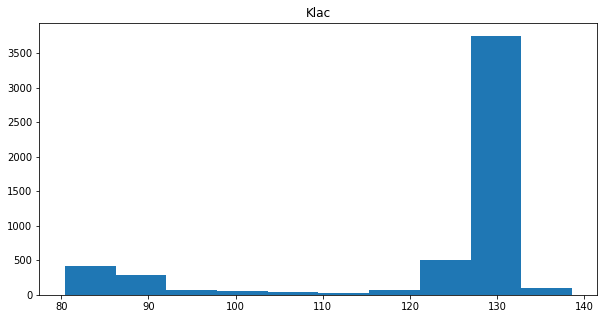

In [67]:
## Show histogram of the pairwise scores and use it to choose thresholds: 


fig, ax = plt.subplots(1,1, figsize=(10,5))

pairwise_scores = {}
for jj, spec in enumerate(['Klac']):
    
    pairwise_score_fname = y1000plus_dir + os.path.normpath('AA_lists/' + spec + "_pairwise_score.pkl")
    
    with open(pairwise_score_fname,'rb') as file: 
        pairwise_score= pickle.load(file)
    
    pairwise_scores[spec] = pairwise_score
    #Use histogram to choose thresholds
    maxvals = []
    for genename_YGOB, options in pairwise_score.items(): 
        idxmax = options.idxmax()
        maxval = options[idxmax]
        maxvals.append(maxval)
    
    #ax = axarr[jj]
    ax.hist(maxvals)
    ax.set_title(spec)

In [68]:
spec = 'Klac'

high_thresh_dict = {'Klac': 110} #{'Ncas':115, 'Smik': 121, 'Klac': 138, 'Ncas_regev':120, 'Klac_regev':138, 'Smik_regev':130}

high_thresh = high_thresh_dict[spec]
low_thresh = high_thresh
diff_thresh = 10.0

study1_study2_map = io_library.pairwise_hits_to_orth_dict(pairwise_scores[spec], high_thresh, low_thresh, diff_thresh)

No Match Klac_1.trna13A
No Match KLLA0D10505g
No Match KLLA0F26961g
No Match KLLA0B13090g
No Match KLLA0C10505g
No Match KLLA0B04950g
No Match KLLA0E22969g
No Match KLLA0E06601g
No Match KLLA0C04809g
No Match KLLA0A10791g
No Match KLLA0F06831g
No Match KLLA0E03807g
No Match KLLA0B07931g
No Match Klac_2.trna15N
No Match KLLA0E07173g
No Match KLLA0E04643g
No Match KLLA0E03895g
No Match KLLA0F12452g
No Match KLLA0D10197g
No Match KLLA0F24728g
No Match KLLA0E04533g
More than one match KLLA0D19987g, diff = 2.70
diff thresh never met KLLA0D19987g
No Match Klac_1.trna9K
No Match KLLA0F08657g
No Match Klac_4.trna34G
No Match Klac_1.trna12Q
No Match KLLA0E21539g
No Match KLLA0B03652g
No Match Klac_6.trna35V
No Match KLLA0E09131g
No Match KLLA0E02157g
No Match KLLA0C07997g
No Match KLLA0E21605g
No Match KLLA0F03597g
No Match Klac_YGOB_Anc_8.419
No Match KLLA0D17894r
No Match KLLA0A10483g
No Match KLLA0D12496g
No Match KLLA0E00265g
No Match KLLA0C00462g
More than one match KLLA0B14553g, diff = 0.

No Match KLLA0A08602g
No Match Klac_3.trna8A
No Match KLLA0F15686g
No Match KLLA0B13673g
No Match KLLA0D03476g
No Match KLLA0F09526g
No Match KLLA0C17534g
No Match KLLA0D14828g
No Match KLLA0F01727g
No Match Klac_6.trna34W
No Match KLLA0F18997g
No Match KLLA0C04004g
No Match KLLA0E12871g
No Match KLLA0F14949g
No Match KLLA0A00891g
More than one match KLLA0C00154g, diff = 2.30
diff thresh never met KLLA0C00154g
No Match KLLA0D06963g
No Match KLLA0A08580g
More than one match KLLA0E17601g, diff = 2.80
No Match KLLA0E10891g
No Match KLLA0F27115g
No Match KLLA0B10648g
More than one match KLLA0A00110g, diff = 4.00
diff thresh never met KLLA0A00110g
No Match Klac_4.trna21S
No Match Klac_4.trna14L
No Match KLLA0C05742g
No Match KLLA0B14146g
No Match KLLA0D03410g
No Match KLLA0C10142g
No Match KLLA0E07679g
No Match KLLA0A01826g
No Match Klac_YGOB_F08657
No Match Klac_YGOB_PMP1
No Match KLLA0A01287g
No Match Klac_CEN2
No Match KLLA0B00781g
No Match KLLA0B13541g
No Match Klac_3.trna11R
No Match K

No Match Klac_4.trna30L
No Match KLLA0C18381g
No Match KLLA0B09306g
No Match KLLA0C00352g
No Match KLLA0E13883g
No Match Klac_5.trna15G
No Match KLLA0F05093g
No Match KLLA0E03455g
No Match KLLA0E00221g
No Match KLLA0D17864g
No Match KLLA0E19119g
No Match KLLA0E05941g
No Match KLLA0F18634g
No Match KLLA0E15401g
No Match KLLA0E24069g
No Match KLLA0C01254g
No Match Klac_YGOB_snR71
No Match KLLA0C08437g
No Match KLLA0C01408g
No Match KLLA0D13574g
No Match KLLA0D04136g
No Match KLLA0E24047g
No Match Klac_5.trna9R
No Match KLLA0F27137g
No Match KLLA0C19382g
No Match KLLA0B06545g
No Match KLLA0E21385g
More than one match KLLA0D00209g, diff = 0.10
No Match KLLA0D13552g
No Match KLLA0E17557g
No Match KLLA0E10847g
No Match KLLA0E09241g
No Match KLLA0E23365g
No Match KLLA0E13355g
No Match KLLA0D12276g
No Match Klac_3.trna10W
No Match KLLA0E19867g
No Match KLLA0C03872g
More than one match KLLA0D04224g, diff = 4.30
No Match KLLA0E23079g
No Match Klac_6.trna23D
No Match Klac_YGOB_Anc_5.18
No Match K

In [72]:
orth_lookup_outputfname = os.path.normpath(io_library.data_processing_dir + 'ortholog_files_y1000/' + spec + "_YGOB-" + spec + "_y1000-orthologs.txt"  )

io_library.print_ortholog_file(orth_lookup_outputfname, study1_study2_map)